<center>
    <h1>Inteligencia Artificial</h1>
    <h1>Clasificación</h1>
    <h1>SVM (Máquinas de Vectores de Soporte)</h1>
    <br>
    <h5>Prof. Wladimir Rodriguez</h5>
    <h5>wladimir.rodriguez@outlook.com</h5>
    <h5>Departamento de Computación</h5>
</center>

# Algoritmos de Clasificación: SVM (Máquinas de Vectores de Soporte)

Una Máquina Vectores de Soporte es un algoritmo de aprendizaje supervisado que puede usarse tanto para problemas de clasificación como para problemas de regresión. Sigue una técnica llamada truco del "kernel" (kernel trick) para transformar los datos y basándose en estas transformaciones, encuentra un límite óptimo entre las salidas posibles.

En palabras simples, hace algunas transformaciones de datos extremadamente complejas para averiguar cómo separar los datos basados en las etiquetas o salidas definidas.

### ¿Cómo funciona?

La idea principal es identificar el hiperplano separador óptimo que maximiza el margen sobre los datos de entrenamiento. Entendamos este término objetivo por término.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats
import pylab as pl
plt.rcParams['figure.figsize'] = (10.0, 8.0)

/Users/wladimir/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


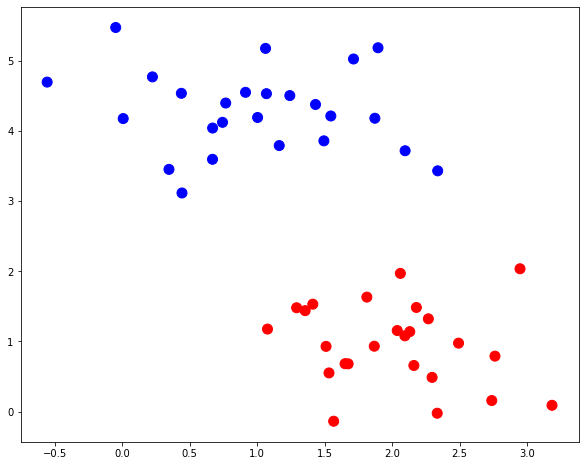

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)

xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=100, cmap='bwr')

Podemos ver que es posible separar los datos dados en la gráfica anterior. Por ejemplo, podemos dibujar una línea en la que todos los puntos por encima de la línea son de color azul y los que están por debajo de la línea son de color rojo. Dicha línea se dice que es un hiperplano de separación.

Ahora la confusión obvia, ¿por qué se llama hiperplano si es una línea?

En el diagrama anterior, hemos considerado el ejemplo más simple, es decir, el conjunto de datos se encuentra en el plano bidimensional $\Re^2$. Pero la máquina soporte también puede funcionar para un conjunto de datos n-dimensional general. Y en el caso de las dimensiones superiores, el hiperplano es la generalización de un plano.

Más formalmente, es un subespacio n-1 dimensional de un espacio euclidiano n-dimensional. Así que para un

- 1D, un solo punto representa el hiperplano.
- 2D, una línea es un hiperplano.
- 3D, un plano es un hiperplano.
- Y en dimensiones superiores, se llama hiperplano.

Hemos dicho que el objetivo de una SVM es encontrar el hiperplano de separación óptimo. ¿Cuándo se dice que un hiperplano de separación es óptimo?

El hecho de que exista un hiperplano que separe el conjunto de datos no significa que sea el mejor.

Vamos a entender el hiperplano óptimo a través de un conjunto de diagramas

### Dibujar tres líneas que separen los datos

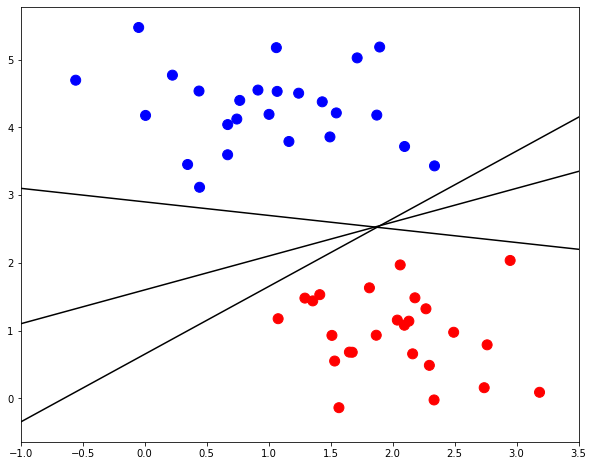

In [3]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=100, cmap='bwr')

# Dibujar tres líneas que separen los datos
for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')

plt.xlim(-1, 3.5);


Pueden haber varias hiperplanos. ¿Cómo encontramos el óptimo? Intuitivamente, si seleccionamos un hiperplano que está cerca de los puntos de datos de una clase, entonces podría no generalizar bien. Por lo tanto, el objetivo es elegir el hiperplano que esté lo más lejos posible de los puntos de datos de cada categoría

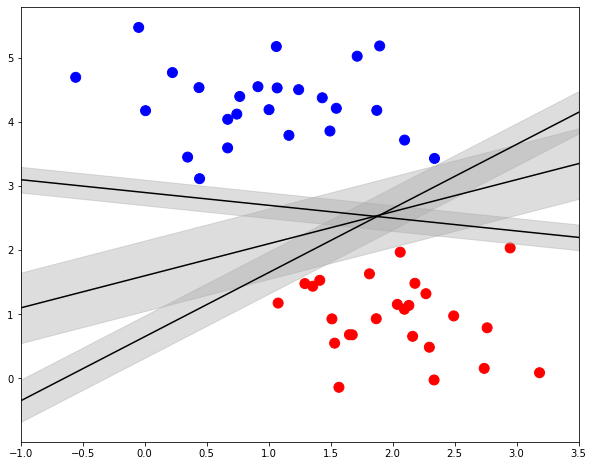

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=100, cmap='bwr')

# Draw three lines that couple separate the data
for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none', color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

Por lo tanto, maximizar la distancia entre los puntos más cercanos de cada clase y el hiperplano resultaría en un hiperplano de separación óptimo. Esta distancia se denomina margen.

El objetivo de SVMs es encontrar el hiperplano óptimo que no sólo clasifique el conjunto de datos existente sino que también ayude a predecir la clase de los datos no vistos. Y el hiperplano óptimo es el que tiene el mayor margen.

## Equación del Hiperplano

La ecuación de una recta es $y = mx + b$, donde $m$ es la pendiente y $b$ es la intercepto con el eje y de la recta.

La ecuación generalizada de un hiperplano es la siguiente:

$$w^Tx = 0$$

Aquí $w$ y $x$ son vectores y $w^Tx$ representa el producto escalar de los dos vectores. El vector $w$ se denomina a menudo vector de pesos.

Considere la ecuación de la recta como $y-mx-b = 0$. En este caso,

$w = \left[\
\begin{array}{ll}
      -b \\
      -m \\
      1 \\
\end{array} 
\right]\ $ y $\ x = \left[\
\begin{array}{ll}
      1 \\
      x \\
      y \\
\end{array} 
\right]$


Es sólo dos maneras diferentes de representar lo mismo. Entonces, ¿por qué usamos $w^Tx = 0$? Simplemente porque es más fácil tratar con esta representación en el caso de un conjunto de datos de mayor dimensión y $w$ representa el vector que es normal al hiperplano. Esta propiedad será útil una vez que comencemos a calcular la distancia de un punto al hiperplano.

### Entendiendo las restricciones

Los datos de entrenamiento en nuestro problema de clasificación son de la forma $((x_1, y_1), (x_2, y_2), ..., (x_n, y_n))$ en $\Re^n \times {-1 , 1}$. Esto significa que el conjunto de datos de entrenamiento es un par de $x_i$, un vector de atributos n-dimensional y $y_i$, la etiqueta de $x_i$. Cuando $y_i = 1$ implica que el ejemplo con el vector de características $x_i$ pertenece a la clase 1 y si $y_i = -1$ implica que la muestra pertenece a la clase -1.

En un problema de clasificación, tratamos de encontrar una función, $y = f (x):\Re^n \longrightarrow \{- 1,1 \}$. $\ f (x)$ aprende del conjunto de datos de entrenamiento y luego aplica su conocimiento para clasificar los datos no vistos.

Hay un número infinito de funciones, $f(x)$ que pueden existir, por lo que tenemos que restringir la clase de funciones con las que estamos tratando. En el caso de SVM, esta clase de funciones es la del hiperplano representado por $w^Tx = 0$.

También puede representarse como $\bar{w}.\bar{x} + b = 0$; $\ \bar{w}\ \epsilon\ \Re^n$ y $b\ \epsilon\ \Re$

Esto divide el espacio de entrada en dos partes, una que contiene vectores de clase -1 y la otra que contiene vectores de clase +1.

Sea $H_0$ un hiperplano que separe el conjunto de datos y que satisfaga lo siguiente:

Junto con $H_0$, podemos seleccionar otros dos hiperplanos $H_1$ y $H_2$ tales que también separen los datos y tengan las siguientes ecuaciones:

$\bar{w}.\bar{x} + b = \delta\ $ y $\ \bar{w}.\bar{x} + b = -\delta$

Esto hace $H_0$ equidistante de $H_1$ así como de $H_2$.

La variable δ no es necesaria por lo que podemos hacer δ = 1 para simplificar el problema como $\bar{w}.\bar{x} + b = 1\ $ y  $\ \bar{w}.\bar{x} + b = -1$

A continuación, queremos asegurarnos de que no hay ningún punto entre ellos. Para ello, seleccionaremos sólo aquellos hiperplanos que satisfagan las siguientes restricciones:

Para cada vector $x_i$:

1. $\bar{w}.\bar{x} + b \leq -1\ $ para los $x_i$ pertenecientes a la clase -1 o
2. $\bar{w}.\bar{x} + b \geq 1\ $ para $x_i$ pertenecientes a la clase 1

<img src="../figuras/svm_margen.png" width=75%>

### Combinando las restricciones

Ambas restricciones mencionadas anteriormente pueden combinarse en una única restricción.

**Restricción 1:**

Para los $x_i$ pertenecientes a la clase -1, $\ \bar{w}.\bar{x} + b \leq -1$

Multiplicando ambos lados por $y_i$ (que es siempre -1 para esta ecuación)

$y_i(\bar{w}.\bar{x} + b) \geq y_i(-1)$ que implica $y_i(\bar{w}.\bar{x} + b) \geq 1\ $ para los $x_i$ pertenecientes a la clase -1.

**Restricción 2:** $\ y_i = 1$

$y_i(\bar{w}.\bar{x} + b) \geq 1\ $ para los $x_i$ pertenecientes a la clase 1.

Combinando ambas ecuaciones anteriores, obtenemos $y_i(\bar{w}.\bar{x} + b) \geq 1\ $ para todos $1 \leq i \leq n$

Esto lleva a una restricción única en vez de dos que son matemáticamente equivalentes. La nueva restricción combinada también tiene el mismo efecto, es decir, no hay puntos entre los dos hiperplanos.

### Maximizando el margen

Por razones de simplicidad, omitiremos la derivación de la fórmula para calcular el margen, $m$ que es

$$m = \frac {2} {||\bar{w}||}$$

La única variable en esta fórmula es $w$, que es indirectamente proporcional a $m$, por lo tanto para maximizar el margen que tendremos que minimizar $||\bar{w}||$. Esto conduce al siguiente problema de optimización:

Minimizar en $(\bar{w}, b)\frac{||\bar{w}||^2}{2}$ sujeto a $\ y_i(\bar{w}.\bar{x} + b) \geq 1\ $ para todos $1 \leq i \leq n$

In [5]:
from sklearn.svm import SVC, LinearSVC
clf = SVC(kernel='linear')
clf.fit(X, y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [6]:
def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function([[xi, yj]])
    # plot the margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

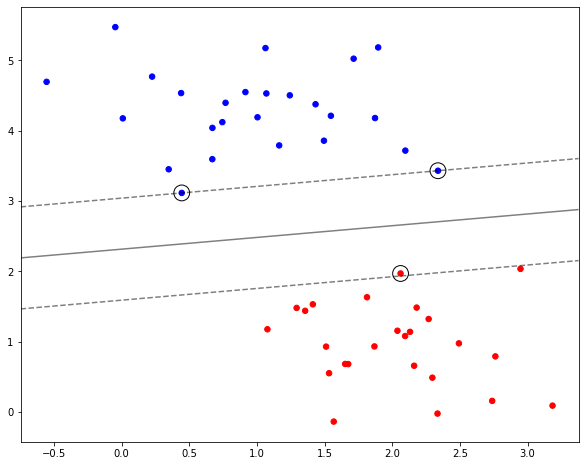

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='bwr')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=250, edgecolor='black', facecolors='none');

## Clases no separables linealmente

Lo anterior es el caso cuando nuestros datos son linealmente separables. Hay muchos casos donde los datos no pueden ser perfectamente clasificados a través de la separación lineal. En estos casos, la Maquina de Vectores de Soporte busca el hiperplano que maximiza el margen y minimiza las clasificaciones erróneas.

Para esto, introducimos la variable de holgura, $\zeta_i$, que permite que algunos ejemplos caigan dentro del margen pero los penaliza.

<img src="../figuras/svm_no_lineal.png" width=75%>

En este escenario, el algoritmo intenta mantener la variable de holgura a cero mientras maximiza el margen. Sin embargo, minimiza la suma de distancias de la clasificación errónea de los hiperplanos de margen y no el número de errores de clasificación.

Las restricciones ahora cambian a $y_i(\bar{w}.\bar{x} + b) \geq 1 - \zeta_i\ $ para todos $1 \leq i \leq n,\  \zeta_i \geq 0$

Y el problema de optimización cambia a

$(\bar{w}, b)\frac{||\bar{w}||^2}{2}+C\sum_i\zeta_i$ sujeto a $\ y_i(\bar{w}.\bar{x} + b) \geq 1 - \zeta_i\ $ para cualquier $i = 1,\dots,n$

Aquí, el parámetro C es el parámetro de regularización que controla el equilibrio entre la penalidad de la variable holgura (errores de clasificación) y el ancho del margen.

- Un $C$ pequeño hace que las limitaciones sean fáciles de ignorar lo que conduce a un margen grande.
- Un $C$ grande permite que las limitaciones dificilmente se ignoren lo que conduce a un margen pequeño.
- Para $C = \inf$, todas las restricciones se aplican.

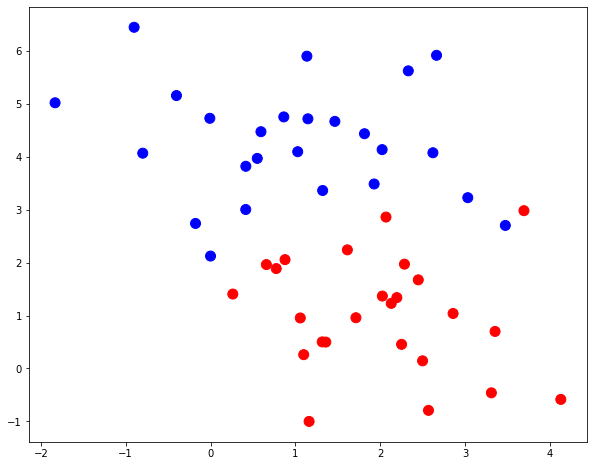

In [9]:
X1, y1 = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=1.10)

xfit = np.linspace(-1, 3.5)
plt.scatter(X1[:, 0], X1[:, 1], c=y1, s=100, cmap='bwr')

### C=1

<Figure size 720x576 with 0 Axes>

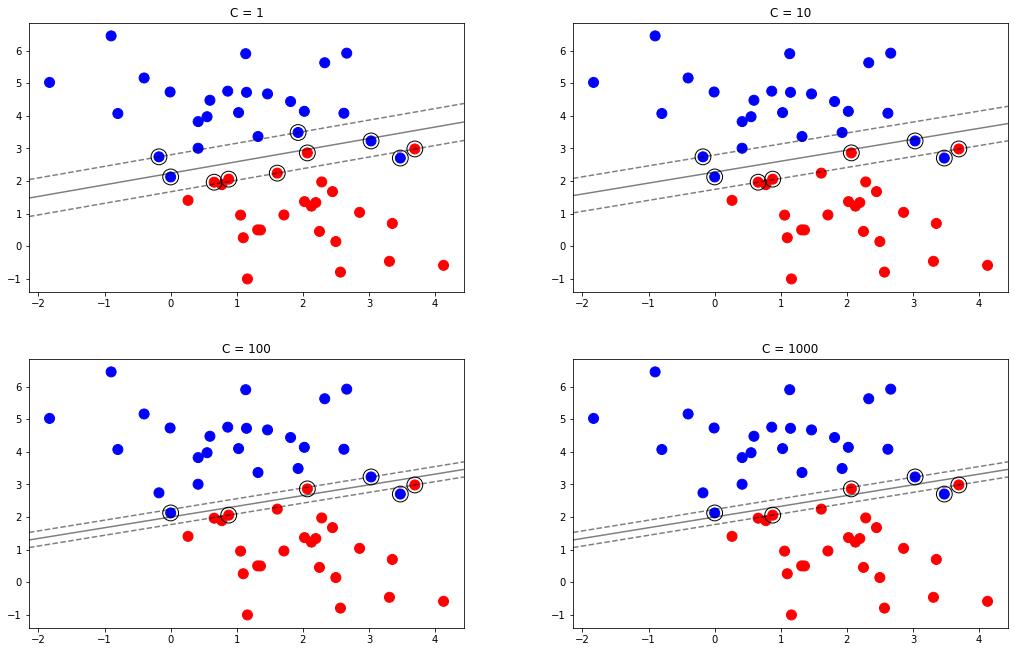

In [10]:
c = [1, 10, 100, 1000]
plt.figure(1)
plt.figure(figsize=(16,10))
for i in range(0, len(c)):
    clf1 = SVC(kernel='linear', C=c[i])
    clf1.fit(X1, y1)
    plt.subplot(221+i)
    plt.scatter(X1[:, 0], X1[:, 1], c=y1, s=100, cmap='bwr')
    plot_svc_decision_function(clf1)
    plt.scatter(clf1.support_vectors_[:, 0], clf1.support_vectors_[:, 1],
            s=250, edgecolor='black', facecolors='none');
    plt.title("C = " + str(c[i]))
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.25)    

## Transformación del Conjunto de Datos a una dimensión mayor

La forma más fácil de separar dos clases de datos es una línea en el caso de datos 2D y un plano en el caso de datos 3D. Pero no siempre es posible utilizar líneas o planos y se requiere una región no lineal para separar estas clases. Las máquinas de vectores de soporte manejan tales situaciones usando una función "kernel" que mapea los datos a un espacio diferente donde un hiperplano lineal puede usarse para separar clases. Esto se conoce como el truco del kernel (kernel trick) en el que la función "kernel" transforma los datos en el espacio de atributos de mayor dimensión para que sea posible una separación lineal.

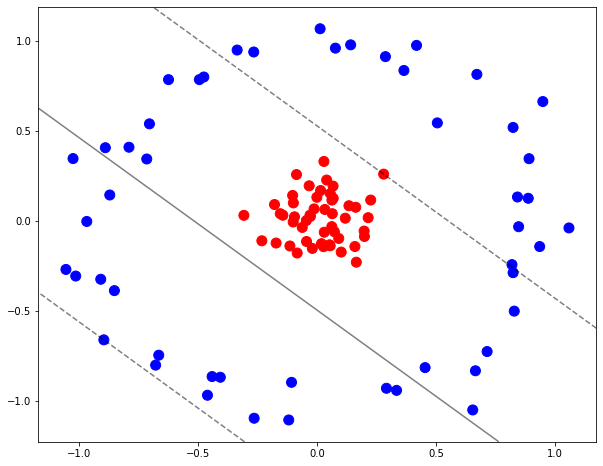

In [11]:
from sklearn.datasets.samples_generator import make_circles
X1, y1 = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X1, y1)

plt.scatter(X1[:, 0], X1[:, 1], c=y1, s=100, cmap='bwr')
plot_svc_decision_function(clf);

### Aplicación del Truco del "Kernel"

Text(0.5, 0, 'r')

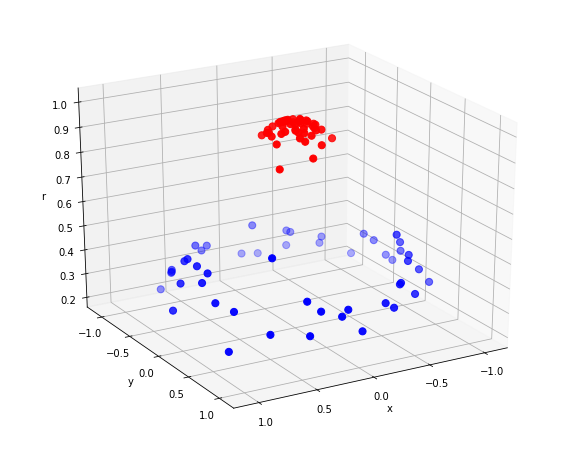

In [12]:
r = np.exp(-(X1[:, 0] ** 2 + X1[:, 1] ** 2))

from mpl_toolkits import mplot3d


ax = plt.subplot(projection='3d')
ax.scatter3D(X1[:, 0], X1[:, 1], r, c=y1, s=50, cmap='bwr')
ax.view_init(elev=25, azim=60)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('r')


### Margen resultante

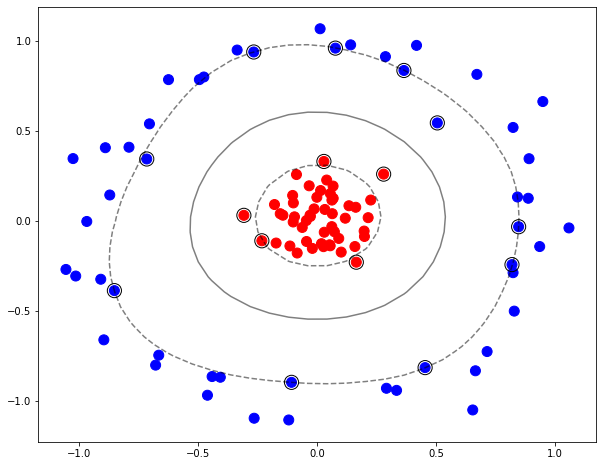

In [13]:
clf = SVC(kernel='rbf')
clf.fit(X1, y1)

plt.scatter(X1[:, 0], X1[:, 1], c=y1, s=100, cmap='bwr')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=200, edgecolor='black', facecolors='none');

## Ventajas y Desventajas de las Maquinas de Vectores de Soporte (SVM)

### Ventajas
- La naturaleza misma del método de Optimización Convexa asegura una óptima optimización. Se garantiza que la solución sea un mínimo global y no un mínimo local.
- SVM es un algoritmo que es adecuado tanto para datos lineales como no lineales (utilizando el truco del núcleo). Lo único que hay que hacer es encontrar al término de regularización, C.
- Los SVMs funcionan bien en espacios de datos de dimensiones pequeñas así como de altas. Funciona eficazmente para los conjuntos de datos de alta dimensión debido al hecho de que la complejidad del conjunto de datos de entrenamiento en SVM se caracteriza generalmente por el número de vectores de soporte en lugar de la dimensionalidad. Incluso si se eliminan todos los demás ejemplos de entrenamiento y se repite el entrenamiento, obtendremos el mismo hiperplano de separación óptimo.
- Los SVM pueden funcionar eficazmente en conjuntos de datos de entrenamiento más pequeños ya que no dependen de los datos completos.

### Desventajas
- No son adecuados para conjuntos de datos muy grandes porque el tiempo de entrenamiento con SVM puede ser alto y mucho más computacionalmente intensivo.
- Son menos eficaces en conjuntos de datos más ruidosos que tienen clases superpuestas.

### Graficar las regiones de decisión para diferentes clasificadores SVM usando el conjunto de datos Iris

Para la comparación usaremos solo dos atributos: largo del sépalo y ancho del sépalo

/Users/wladimir/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


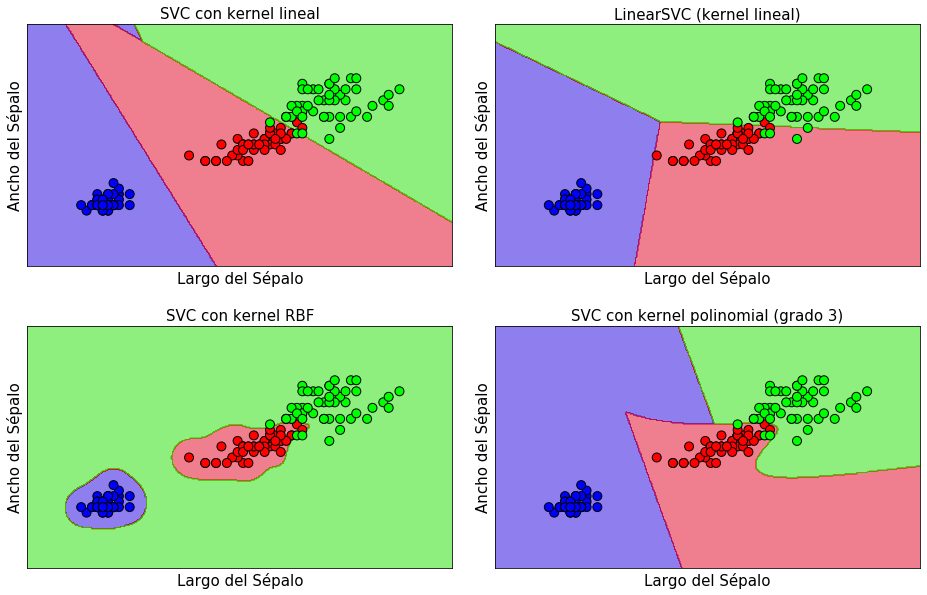

In [14]:
from matplotlib import colors as c
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm
%matplotlib inline
iris = datasets.load_iris()
X = iris.data[:,2:4]  # solo se toman dos atributos.
y = iris.target
h = .02  # resolución de la malla

# crear una isntancia de SVM y ajustarlo a los datos.
C = 10.0  # SVM parametro de regularización
svc = svm.SVC(kernel='linear', C=C).fit(X, y)
rbf_svc = svm.SVC(kernel='rbf', gamma=10, C=C).fit(X, y)
poly_svc = svm.SVC(kernel='poly', degree=8, C=C).fit(X, y)
lin_svc = svm.LinearSVC(C=C).fit(X, y)

# crear una maya para graficar en ella
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# titulos de los graficos
titles = ['SVC con kernel lineal',
          'LinearSVC (kernel lineal)',
          'SVC con kernel RBF',
          'SVC con kernel polinomial (grado 3)']

plt.figure(figsize=(16,10))
for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
    # Graficar la regiones de decisión. Para lo cual se le asignará un color a cada una
    # puntos en la malla [x_min, m_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.1, hspace=0.25)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Colocar los resultados en un grafico a color
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap='brg', alpha=0.5)

    # Graficar los datos de entrenamiento
    plt.scatter(X[:, 0], X[:, 1], s=80, c=y, cmap='brg', edgecolor='black')
    plt.xlabel('Largo del Sépalo',fontsize=15)
    plt.ylabel('Ancho del Sépalo',fontsize=15)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i],fontsize=15)

plt.show()

### Selección de los hiperparametros

Los parámetros son los siguientes:

- C: Es el parámetro de regularización, C, del término de error. El parámetro C regula el compromiso entre la mala clasificación de los ejemplos de entrenamiento contra la simplicidad de la superficie de decisión. Un C bajo hace que la superficie de la decisión sea suave, mientras que un C alto busca clasificar correctamente todos los ejemplos de entrenamiento dando al modelo libertad para seleccionar más muestras como vectores de soporte
- kernel: Especifica el tipo de kernel que se utilizará en el algoritmo. Puede ser 'lineal', 'poly', 'rbf', 'sigmoid', 'precomputed' o un callable. El valor predeterminado es 'rbf'.
- degree: Es el grado de la función polinomial kernel ('poly') y es ignorado por todos los demás kernels. El valor predeterminado es 3.
- gamma: Es el coeficiente de kernel para 'rbf', 'poly' y 'sigmoid'. Intuitivamente, el parámetro gamma define que tan lejos llega la influencia de un solo ejemplo de entrenamiento, con valores bajos que significan 'lejos' y valores altos que significan 'cerca'. Los parámetros gamma pueden ser vistos como la inversa del radio de influencia de los ejemplos seleccionados por el modelo como vectores de soporte. Si gamma es 'auto', entonces 1 / n_features se utilizará en su lugar.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

X = iris.data
y = iris.target

X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(X, y, stratify=y, random_state=0)

# Fijar los parametros para la validación cruzada
parameters = [{'kernel': ['rbf'],
               'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5],
                'C': [1, 10, 100, 1000]},
              {'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
             {'kernel': ['poly'],
              'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5],
             'degree': [3, 5, 7],
             'C': [1, 10, 100, 1000]}]

print("# Selección de los hiperparámetros")
print()

clf = GridSearchCV(svm.SVC(decision_function_shape='ovr'), parameters, cv=5)
clf.fit(X_entrenamiento, y_entrenamiento)

print("Mejores parametros encontrados para el conjunto de validación:")
print()
print(clf.best_params_)
print()
print("Valores de exactitud sobre el conjunto de entrenamineto:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

# Selección de los hiperparámetros

Mejores parametros encontrados para el conjunto de validación:

{'C': 100, 'degree': 3, 'gamma': 0.01, 'kernel': 'poly'}

Valores de exactitud sobre el conjunto de entrenamineto:

0.588 (+/-0.509) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.734 (+/-0.268) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.902 (+/-0.066) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.929 (+/-0.069) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.929 (+/-0.118) for {'C': 1, 'gamma': 0.2, 'kernel': 'rbf'}
0.938 (+/-0.068) for {'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}
0.734 (+/-0.268) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.911 (+/-0.080) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.947 (+/-0.085) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.938 (+/-0.089) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.928 (+/-0.044) for {'C': 10, 'gamma': 0.2, 'kernel': 'rbf'}
0.938 (+/-0.043) for {'C': 10, 'gamma': 0.5, 'kernel': 'rbf'}
0.911 (+/-0.080) for {'C': 100, 'g

In [16]:
print("Reporte detallado de la clasificación:")
print()
print("El modelo es entreando sobre todo el conjunto de entrenamiento.")
print("Los valores de precisión, recuperación y f1 son calculados sobre el conjunto de prueba.")
print()
y_verdadero, y_predecido = y_prueba, clf.predict(X_prueba)
print(classification_report(y_verdadero, y_predecido))
print()

Reporte detallado de la clasificación:

El modelo es entreando sobre todo el conjunto de entrenamiento.
Los valores de precisión, recuperación y f1 son calculados sobre el conjunto de prueba.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        12

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38


